In [ ]:
import sys
!{sys.executable} -m pip install tensorflow==2.5.0 logomaker networkx

In [1]:
import os
import numpy as np
import msa_hmm
from matplotlib import pyplot as plt

## MSA HMM Interactive

1. Fit n models, keep the best and align
2. Compare to a reference
3. Visualize the HMM

Change the variables in the following cell to fit your needs.

In [2]:
# your fasta file with unaligned sequences
train_filename = "test/data/egf.fasta"
# if your file already contains gaps, change this flag to let them be removed
train_file_contains_gaps = False
# reference file with aligned sequences that have matching IDs to seqs in the train_file
# replace with empty string if no reference is available
ref_filename = "test/data/egf.ref"
# number of independently trained models
num_runs = 1

## Training

In [3]:
# load the file
fasta_file = msa_hmm.fasta.Fasta(train_filename, 
                                 gaps=train_file_contains_gaps, 
                                 contains_lower_case=True)  
# optionally load the reference and find the corresponding sequences in the train file
if ref_filename != "":
    ref_fasta = msa_hmm.fasta.Fasta(ref_filename, gaps=True, contains_lower_case=True)
    subset = np.array([fasta_file.seq_ids.index(sid) for sid in ref_fasta.seq_ids])
else:
    subset = None
results = msa_hmm.align.fit_and_align_n(fasta_file, 
                                        num_runs=num_runs,
                                        config=msa_hmm.config.default,
                                        subset=subset)
best = np.argmax([ll for ll,_ in results])
best_ll, best_alignment = results[best]
print("Computed alignments with likelihoods:", [ll for ll,_ in results])
print("Best model has likelihood:", best_ll)
out_filepath = "test/data/interactive.alignment.fasta"
best_alignment.to_file(out_filepath)
if ref_filename != "":
    out_file = msa_hmm.fasta.Fasta(out_filepath, 
                             gaps=True, 
                             contains_lower_case=True) 
    _,r = out_file.precision_recall(ref_fasta)
    tc = out_file.tc_score(ref_fasta)
    print("SP score =", r, "TC score =", tc)

Training of 1 independent models on file egf.fasta
Configuration:
transition_init : default , flank_init : default , emission_init : background
 , alpha_flank : 7000 , alpha_single : 1000000000.0 , alpha_frag : 10000.0
 , max_surgery_runs : 4 , surgery_quantile : 0.5 , min_surgery_seqs : 10000.0
 , len_mul : 0.8 , batch_size : adaptive , use_prior : True
 , dirichlet_mix_comp_count : 1 , use_anc_probs : True , tau_init : 0.0
 , keep_tau : False
7774 sequences of max. length 67
Fitting a model of length 24 on 7774 sequences.
Batch size= 512 Learning rate= 0.1
Using 2 GPUs.
Epoch 1/2
43/43 - 13s - loss: 82.3391 - loglik: -7.9639e+01 - logprior: -2.6996e+00
Epoch 2/2
43/43 - 3s - loss: 63.3698 - loglik: -6.1756e+01 - logprior: -1.6138e+00
expansions: [(7, 1), (10, 1), (11, 2), (12, 3), (13, 1), (14, 1), (15, 1)]
discards: [0]
Fitting a model of length 33 on 7774 sequences.
Batch size= 512 Learning rate= 0.1
Using 2 GPUs.
43/43 - 12s - loss: 64.0771 - loglik: -6.1124e+01 - logprior: -2.953

## Alignment

In [4]:
# print the alignment
max_seq = 20
msa = best_alignment.to_string()
for s in msa[:max_seq]:
    print(s)
if len(msa) > max_seq:
    print(len(msa) - max_seq, "sequences omitted.")

..vdgdq$CESN...PCLNGGSC..K...D...DIN..S..YECWCPFGFEGKN$cel....................
..kdgdq$CEGH...PCLNQGHC..K...D...GIG..D..YTCTCAEGFEGKN$cefstr.................
.....qv$PSNC...DCLNGGTC..V...SnkyFSN..I..HWCNCPKKFGGQH$ceidk..................
....tas$CQDM...SCSKQGEC..L...E...TIG..N..YTCSCYPGFYGPE$ceyvre.................
......a$CTNT...SCSGHGEC..V...E...TIN..N..YTCKCDPGFSGLK$ceqiv..................
gtshlvk$CAEKektFCVNGGEC..FmvkD...LSNpsR..YLCKCQPGFTGAR$ctenvpmkvqnqekaeelyqk..
..nsypg$CPSSydgYCLNGGVCmhI...E...SLD..S..YTCNCVIGYSGDR$cqtrdlrwwelr...........
vvshfnd$CPDShtqFCFH-GTC..R...F...LVQ..EdkPACVCHSGYVGAR$cehadlla...............
.......$CSLD...NGDCDQFC..H...E...EQN..S..VVCSCARGYTLAD$ngkaciptgpypcgkqtler...
....gdq$CASS...PCQNGGSC..K...D...QLQ..S..YICFCLPAFEGRN$cethkd.................
...dqli$CVNE...NGGCEQYC..S...D...HTG..Tk.RSCRCHEGYSLLA$dgvsctptveypcgkipile...
.....mt$CNIK...NGRCEQFC..K...N...SAD..Nk.VVCSCTEGYRLAE$nqkscepavpfpcgrvsvsqtsk


## Plot the consensus sequence logo of the trained model

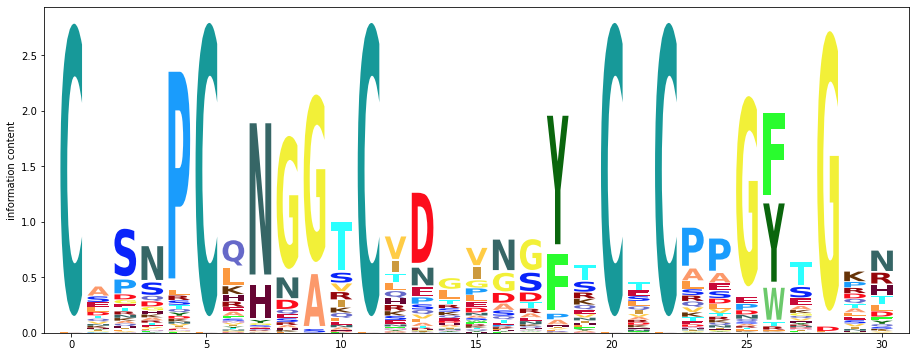

In [5]:
fig, ax = plt.subplots()
msa_hmm.vis.make_logo(best_alignment, ax)

## Plot the HMM plus a hidden sequence 

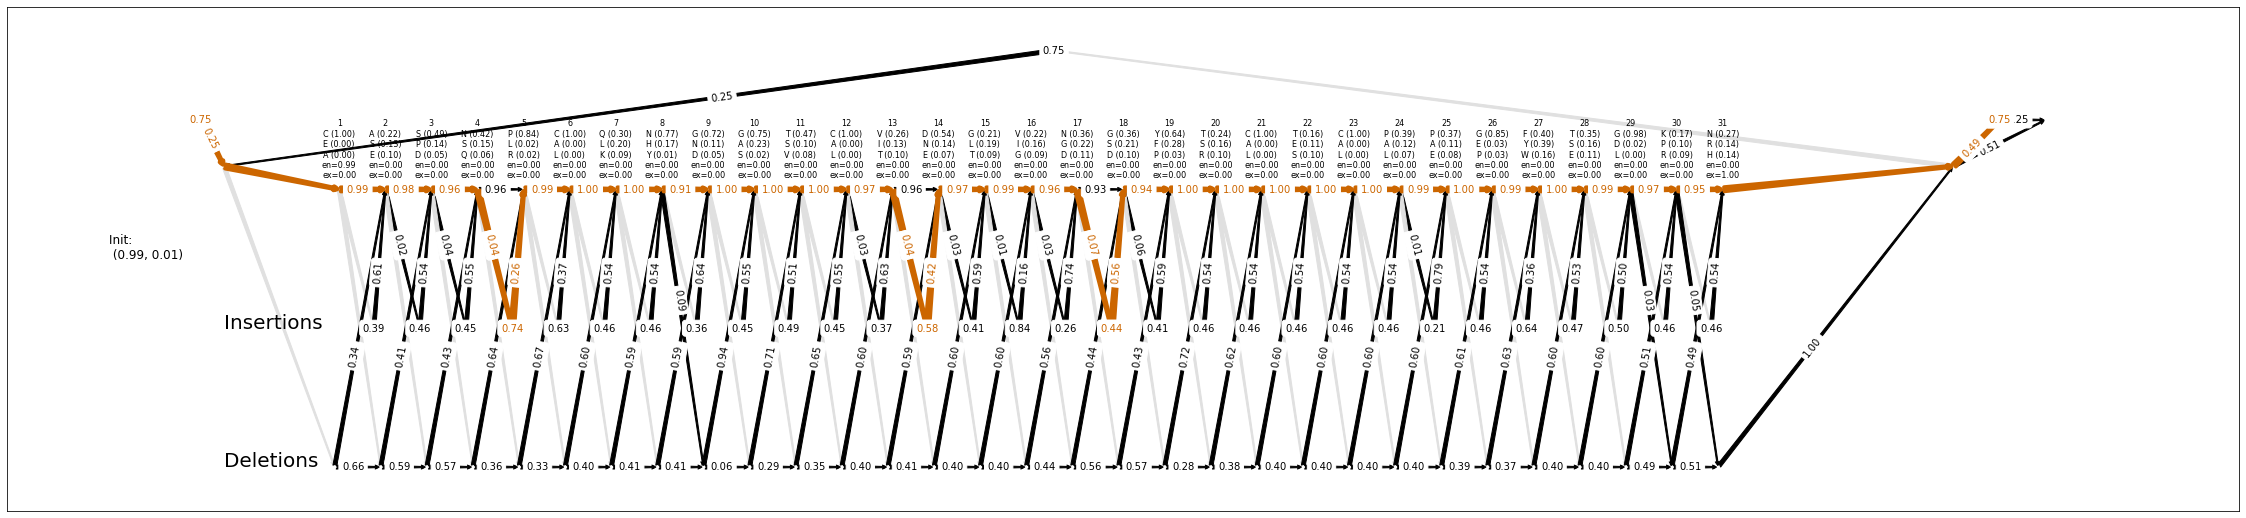

In [6]:
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
msa_hmm.vis.plot_hmm(best_alignment, ax, seq_i=5)